# Natural Lenguague Processing


### Importing some Libs and Modules

In [ ]:
!wget https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/helper_functions.py

In [ ]:
from helper_functions import unzip_data, create_tensorboard_callback, plot_loss_curves, compare_historys
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import random
import tensorflow as tf
import tensorflow_hub as hub
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.layers.experimental import preprocessing
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.layers import Dense, Flatten, Conv2D, MaxPool2D, Activation
from tensorflow.keras import Sequential
import os
import pandas as pd

### What is a Recurrent Neural Network (RNN)


A recurrent neural network (RNN) is like a smart system that **remembers** things it has seen before, and uses that memory to understand and process new information. It's designed to work with sequences of data, like words in a sentence or steps in a process. Each step of an RNN considers both the current input and what it has learned from previous steps, allowing it to capture patterns and relationships in the data over time. This makes RNNs really good at tasks like language translation, speech recognition, and predicting sequences.

- Sequence to Sequence (seq2seq)

## Get a text dataset

- We are going to use a Kaggle dataset introducction to NLP: Disaster Tweets

In [ ]:
# Download the dataset
!wget https://storage.googleapis.com/ztm_tf_course/nlp_getting_started.zip

# Unzip
unzip_data("nlp_getting_started.zip")

## Visualize our data

In [ ]:
# load our data

train_df = pd.read_csv("train.csv")
test_df = pd.read_csv("test.csv")

train_df.head(20)

In [ ]:
# Visualize some random training examples
random_index = random.randint(0, len(train_df)-5)
for row in train_df[['text', 'target']][random_index:random_index+5].itertuples():
  _, text, target = row
  print(f"Target: {target}", "Real" if target > 0 else "Not real")
  print(f"Text:\n {text}\n")
  print("---\n")

## Preprocess our data

- **Tokenization** - A straight mapping from word or character or sub-word to a numerical value. There are three main levels of tokenization:
    * **Using word-level tokenization** with the sentence "I love TensorFlow" might result in "I" being 0, "love" being 1 and "TensorFlow" being 2. In this case, every word in a sequence considered a single token.
    * **Character-level tokenization**, such as converting the letters A-Z to values 1-26. In this case, every character in a sequence considered a single token.
    * **Sub-word** tokenization is in between word-level and character-level tokenization. It involves breaking invidual words into smaller parts and then converting those smaller parts into numbers. For example, "my favourite food is pineapple pizza" might become "my, fav, avour, rite, fo, oo, od, is, pin, ine, app, le, piz, za". After doing this, these sub-words would then be mapped to a numerical value. In this case, every word could be considered multiple tokens.
- **Embeddings** - An embedding is a representation of natural language which can be learned. Representation comes in the form of a feature vector. For example, the word "dance" could be represented by the 5-dimensional vector [-0.8547, 0.4559, -0.3332, 0.9877, 0.1112]. It's important to note here, the size of the feature vector is tuneable. There are two ways to use embeddings:
    * **Create your own embedding** - Once your text has been turned into numbers (required for an embedding), you can put them through an embedding layer (such as tf.keras.layers.Embedding) and an embedding representation will be learned during model training.
    * **Reuse a pre-learned embedding** - Many pre-trained embeddings exist online. These pre-trained embeddings have often been learned on large corpuses of text (such as all of Wikipedia) and thus have a good underlying representation of natural language. You can use a pre-trained embedding to initialize your model and fine-tune it to your own specific task.

In [ ]:
 from sklearn.model_selection import train_test_split

# Use train_test_split to split training data into training and validation sets
train_sentences, val_sentences, train_labels, val_labels = train_test_split(train_df["text"].to_numpy(),
                                                                            train_df["target"].to_numpy(),
                                                                            test_size=0.1, # dedicate 10% of samples to validation set
                                                                            random_state=42) # random state for reproducibil

### Text Vectorization

In [ ]:
from tensorflow.keras.layers.experimental.preprocessing import TextVectorization

# Use the default TextVectorization parameters
text_vectorizer = TextVectorization(max_tokens = None, # if a word is not frecuently used then is replaced with a token (<OOV>)
                                         standardize="lower_and_strip_punctuation", # Just take the letters and ignore the symbols
                                         split="whitespace", #Space between the tokens
                                         ngrams=None, # Creates a group of n-words
                                         output_mode="int", # How to map token to numbers
                                         output_sequence_length=None) # how long do you want your sequences



In [ ]:
# Find the average number of tokens (words) in the training tweets
round(sum([len(i.split()) for i in train_sentences])/len(train_sentences))

In [ ]:
# Setup text vectorization variables
max_vocab_length = 10000 # Max number of words to have in our vocabulary
max_length = 15 # max length our sequencues will be

# Use TextVectorization parameters
text_vectorizer = TextVectorization(max_tokens = max_vocab_length, # if a word is not frecuently used then is replaced with a token (<OOV>)
                                         standardize="lower_and_strip_punctuation", # Just take the letters and ignore the symbols
                                         split="whitespace", #Space between the tokens
                                         ngrams=None, # Creates a group of n-words
                                         output_mode="int", # How to map token to numbers
                                         output_sequence_length=max_length, # how long do you want your sequences
                                         pad_to_max_tokens=True )

In [ ]:
# Fit the text vectorizer to the training text
text_vectorizer.adapt(train_sentences)

In [ ]:
# Create a sample sentence and tokenize it
sample_sequence = "There's a flood in my street!"
text_vectorizer([sample_sequence])

In [ ]:
# Get the unique words in the vocabulary
words_in_vocab  = text_vectorizer.get_vocabulary() # Get all of the unique words in our traning data
top_5_words = words_in_vocab[:5] # Get the most common words
bottom_5_words = words_in_vocab[-5:]
print(top_5_words)
print(bottom_5_words)

### Create an Embedding using Embedding layer


* input_dim : The size of our vocabulary
* output_dim : The size of the output embeding vector
* input_length : Length of sequences being passed to the embedding layer

In [ ]:
embedding = layers.Embedding(input_dim=max_vocab_length, output_dim=128, # for output always is better some number 8 divisible
                             input_length=max_length)

embedding

In [ ]:
# Get a random sentence from the traning set
random_sentence = random.choice(train_sentences)
print(random_sentence)

#Embedded the random sentence
sample_embed = embedding(text_vectorizer([random_sentence]))
print(sample_embed)



In [ ]:
# Check out a single token's embedding
sample_embed[0][0], sample_embed[0][0].shape, random_sentence[0]

In [ ]:
# Create tensorboard callback (need to create a new one for each model)
from helper_functions import create_tensorboard_callback

# Create directory to save TensorBoard logs
SAVE_DIR = "model_logs"

## Model our datasets

- **Model 0: Naive Bayes** (baseline)
- **Model 1: Feed-forward neural network** (dense model)
- **Model 2: LSTM model** - Most Popular
- **Model 3: GRU model** - Very similar to LSTM
- **Model 4: Bidirectional RNN**-LSTM model but forward and backwards sequences
- **Model 5: 1D Convolutional Neural Network**
- **Model 6: TensorFlow Hub Pretrained Feature Extractor**
- **Model 7: 10% Data** Same as model 6 with 10% of training data

Each experiment will go through the following steps:

- Construct the model
- Train the model
- Make predictions with the model
- Track prediction evaluation metrics for later comparison

### Model 0: Getting a baseline
As with all machine learning modelling experiments, it's important to create a baseline model so you've got a benchmark for future experiments to build upon.

To create our baseline, we'll create a Scikit-Learn Pipeline using the TF-IDF (term frequency-inverse document frequency) formula to convert our words to numbers and then model them with the Multinomial Naive Bayes algorithm. This was chosen via referring to the Scikit-Learn machine learning map.

In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.pipeline import Pipeline

# Create tokenization and modelling pipeline
model_0 = Pipeline([
                    ("tfidf", TfidfVectorizer()), # convert words to numbers using tfidf
                    ("clf", MultinomialNB()) # model the text
])

# Fit the pipeline to the training data
model_0.fit(train_sentences, train_labels)

In [ ]:
baseline_score = model_0.score(val_sentences, val_labels)
print(f"Our baseline model achieves an accuracy of: {baseline_score*100:.2f}%")

In [ ]:
# Make predictions
baseline_preds = model_0.predict(val_sentences)
baseline_preds[:20]

### Creating an evaluation function for our model experiments
We could evaluate these as they are but since we're going to be evaluating several models in the same way going forward, let's create a helper function which takes an array of predictions and ground truth labels and computes the following:

- Accuracy
- Precision
- Recall
- F1-score

In [ ]:
# Function to evaluate: accuracy, precision, recall, f1-score
from sklearn.metrics import accuracy_score, precision_recall_fscore_support

def calculate_results(y_true, y_pred):
  """
  Calculates model accuracy, precision, recall and f1 score of a binary classification model.

  Args:
  -----
  y_true = true labels in the form of a 1D array
  y_pred = predicted labels in the form of a 1D array

  Returns a dictionary of accuracy, precision, recall, f1-score.
  """
  # Calculate model accuracy
  model_accuracy = accuracy_score(y_true, y_pred) * 100
  # Calculate model precision, recall and f1 score using "weighted" average
  model_precision, model_recall, model_f1, _ = precision_recall_fscore_support(y_true, y_pred, average="weighted")
  model_results = {"accuracy": model_accuracy,
                  "precision": model_precision,
                  "recall": model_recall,
                  "f1": model_f1}
  return model_results

In [ ]:
# Get baseline results
baseline_results = calculate_results(y_true=val_labels,
                                     y_pred=baseline_preds)
baseline_results

### Model 1: Simple Dense Model

In [ ]:
# Build model with the Functional API
from tensorflow.keras import layers
inputs = layers.Input(shape=(1,), dtype="string") # inputs are 1-dimensional strings
x = text_vectorizer(inputs) # turn the input text into numbers
x = embedding(x) # create an embedding of the numerized numbers
x = layers.GlobalAveragePooling1D()(x) # lower the dimensionality of the embedding (try running the model without this layer and see what happens)
outputs = layers.Dense(1, activation="sigmoid")(x) # create the output layer, want binary outputs so use sigmoid activation
model_1 = tf.keras.Model(inputs, outputs, name="model_1_dense") # construct the model

In [ ]:
# Compile model
model_1.compile(loss="binary_crossentropy",
                optimizer=tf.keras.optimizers.Adam(),
                metrics=["accuracy"])

In [ ]:
# Fit the model
model_1_history = model_1.fit(train_sentences, # input sentences can be a list of strings due to text preprocessing layer built-in model
                              train_labels,
                              epochs=5,
                              validation_data=(val_sentences, val_labels),
                              callbacks=[create_tensorboard_callback(dir_name=SAVE_DIR,
                                                                     experiment_name="simple_dense_model")])

In [ ]:
model_1.summary()

In [ ]:
# Check the results
model_1.evaluate(val_sentences, val_labels)

In [ ]:
embed_weights = model_1.get_layer("embedding_1").get_weights()[0]
print(embed_weights.shape)

In [ ]:
# Make predictions on the validation dataset
model_1_pred_probs = model_1.predict(val_sentences)
model_1_pred_probs.shape, model_1_pred_probs[:10] # view the first 10

# Round out predictions and reduce to 1-dimensional array
model_1_preds = tf.squeeze(tf.round(model_1_pred_probs))
model_1_preds[:10]

# Calculate LSTM model results
model_1_results = calculate_results(y_true=val_labels,
                                    y_pred=model_1_preds)
model_1_results

In [ ]:
# Load the TensorBoard notebook extension
%load_ext tensorboard

In [ ]:
# # View tensorboard logs of transfer learning modelling experiments (should be 4 models)
# # Upload TensorBoard dev records
%tensorboard --logdir ./model_logs

### Recurrent Neural Networks (RNN's)

Recurrent neural networks can be used for a number of sequence-based problems:

- One to one: one input, one output, such as image classification.
- One to many: one input, many outputs, such as image captioning (image input, a sequence of text as caption output).
- Many to one: many inputs, one outputs, suchWhen you come across RNN's in the wild, you'll most likely come across variants of the following:

Long short-term memory cells (LSTMs).
- Gated recurrent units (GRUs).
- Bidirectional RNN's (passes forward and backward along a sequence, left to right and right to left).

Going into the details of each these is beyond the scope of this notebook (we're going to focus on using them instead), the main thing you should know for now is that they've proven very effective at modelling sequences. as text classification (classifying a Tweet as real diaster or not real diaster).
- Many to many: many inputs, many outputs, such as machine translation (translating English to Spanish) or speech to text (audio wave as input, text as output).



### Model 2: LSTM

Our model is going to take on a very similar structure to model_1:

Input (text) -> Tokenize -> Embedding -> Layers -> Output (label probability)
The main difference will be that we're going to add an LSTM layer between our embedding and output.

And to make sure we're not getting reusing trained embeddings (this would involve data leakage between models, leading to an uneven comparison later on), we'll create another embedding layer (model_2_embedding) for our model. The text_vectorizer layer can be reused since it doesn't get updated during training.

In [ ]:
# Set random seed and create embedding layer (new embedding layer for each model)
tf.random.set_seed(42)
from tensorflow.keras import layers
model_2_embedding = layers.Embedding(input_dim=max_vocab_length,
                                     output_dim=128,
                                     embeddings_initializer="uniform",
                                     input_length=max_length,
                                     name="embedding_2")


# Create LSTM model
inputs = layers.Input(shape=(1,), dtype="string")
x = text_vectorizer(inputs)
x = model_2_embedding(x)
print(x.shape)
x = layers.LSTM(64, return_sequences=True)(x) # return vector for each word in the Tweet (you can stack RNN cells as long as return_sequences=True)
x = layers.LSTM(64)(x) # return vector for whole sequence
print(x.shape)
x = layers.Dense(64, activation="relu")(x) # optional dense layer on top of output of LSTM cell
outputs = layers.Dense(1, activation="sigmoid")(x)
model_2 = tf.keras.Model(inputs, outputs, name="model_2_LSTM")

In [ ]:
# Compile model
model_2.compile(loss="binary_crossentropy",
                optimizer=tf.keras.optimizers.Adam(),
                metrics=["accuracy"])

In [ ]:

# Fit model
model_2_history = model_2.fit(train_sentences,
                              train_labels,
                              epochs=5,
                              validation_data=(val_sentences, val_labels),
                              callbacks=[create_tensorboard_callback(SAVE_DIR,
                                                                     "LSTM")])

In [ ]:
# Make predictions on the validation dataset
model_2_pred_probs = model_2.predict(val_sentences)
model_2_pred_probs.shape, model_2_pred_probs[:10] # view the first 10

In [ ]:
# Round out predictions and reduce to 1-dimensional array
model_2_preds = tf.squeeze(tf.round(model_2_pred_probs))
model_2_preds[:10]

In [ ]:
# Calculate LSTM model results
model_2_results = calculate_results(y_true=val_labels,
                                    y_pred=model_2_preds)
model_2_results

In [ ]:
model_1_results

In [ ]:
baseline_results

### Model 3: GRU

Another popular and effective RNN component is the GRU or gated recurrent unit.

The GRU cell has similar features to an LSTM cell but has less parameters.


> 📖 Resource: A full explanation of the GRU cell is beyond the scope of this notebook but I'd suggest the following resources to learn more:

- Gated Recurrent Unit Wikipedia page
- Understanding GRU networks by Simeon Kostadinov
- To use the GRU cell in TensorFlow, we can call the tensorflow.keras.layers.GRU() class.

The architecture of the GRU-powered model will follow the same structure we've been using:

Input (text) -> Tokenize -> Embedding -> Layers -> Output (label probability)

Again, the only difference will be the layer(s) we use between the embedding and the output.

In [ ]:
# Set random seed and create embedding layer (new embedding layer for each model)
tf.random.set_seed(42)
from tensorflow.keras import layers
model_3_embedding = layers.Embedding(input_dim=max_vocab_length,
                                     output_dim=128,
                                     embeddings_initializer="uniform",
                                     input_length=max_length,
                                     name="embedding_3")

# Build an RNN using the GRU cell
inputs = layers.Input(shape=(1,), dtype="string")
x = text_vectorizer(inputs)
x = model_3_embedding(x)
# x = layers.GRU(64, return_sequences=True) # stacking recurrent cells requires return_sequences=True
x = layers.GRU(64)(x)
# x = layers.Dense(64, activation="relu")(x) # optional dense layer after GRU cell
outputs = layers.Dense(1, activation="sigmoid")(x)
model_3 = tf.keras.Model(inputs, outputs, name="model_3_GRU")

In [ ]:
# Compile GRU model
model_3.compile(loss="binary_crossentropy",
                optimizer=tf.keras.optimizers.Adam(),
                metrics=["accuracy"])

In [ ]:
# Fit model
model_3_history = model_3.fit(train_sentences,
                              train_labels,
                              epochs=5,
                              validation_data=(val_sentences, val_labels),
                              callbacks=[create_tensorboard_callback(SAVE_DIR, "GRU")])

In [ ]:
# Make predictions on the validation dataset
model_3_pred_probs = model_3.predict(val_sentences)
model_3_pred_probs.shape, model_3_pred_probs[:10] # view the first 10

# Round out predictions and reduce to 1-dimensional array
model_3_preds = tf.squeeze(tf.round(model_3_pred_probs))
model_3_preds[:10]

# Calculate LSTM model results
model_3_results = calculate_results(y_true=val_labels,
                                    y_pred=model_3_preds)
model_3_results

### Model 4: Bidirectonal RNN model

A standard RNN will process a sequence from left to right, where as a bidirectional RNN will process the sequence from left to right and then again from right to left.

Intuitively, this can be thought of as if you were reading a sentence for the first time in the normal fashion (left to right) but for some reason it didn't make sense so you traverse back through the words and go back over them again (right to left).

In practice, many sequence models often see and improvement in performance when using bidirectional RNN's.

However, this improvement in performance often comes at the cost of longer training times and increased model parameters (since the model goes left to right and right to left, the number of trainable parameters doubles).

In [ ]:
# Set random seed and create embedding layer (new embedding layer for each model)
tf.random.set_seed(42)
from tensorflow.keras import layers
model_4_embedding = layers.Embedding(input_dim=max_vocab_length,
                                     output_dim=128,
                                     embeddings_initializer="uniform",
                                     input_length=max_length,
                                     name="embedding_4")

# Build a Bidirectional RNN in TensorFlow
inputs = layers.Input(shape=(1,), dtype="string")
x = text_vectorizer(inputs)
x = model_4_embedding(x)
# x = layers.Bidirectional(layers.LSTM(64, return_sequences=True))(x) # stacking RNN layers requires return_sequences=True
x = layers.Bidirectional(layers.LSTM(64))(x) # bidirectional goes both ways so has double the parameters of a regular LSTM layer
outputs = layers.Dense(1, activation="sigmoid")(x)
model_4 = tf.keras.Model(inputs, outputs, name="model_4_Bidirectional")

In [ ]:
# Compile GRU model
model_4.compile(loss="binary_crossentropy",
                optimizer=tf.keras.optimizers.Adam(),
                metrics=["accuracy"])

In [ ]:
# Fit the model (takes longer because of the bidirectional layers)
model_4_history = model_4.fit(train_sentences,
                              train_labels,
                              epochs=5,
                              validation_data=(val_sentences, val_labels),
                              callbacks=[create_tensorboard_callback(SAVE_DIR, "bidirectional_RNN")])

https://chat.openai.com/share/00374af5-3ba0-4f51-802c-98e88307c96e

https://www.perplexity.ai/search/Create-me-a-UGROC7GNTSG4FPklRT5qcg?s=c


https://gemini.google.com/u/2/app/481c49cd2d7f8c47


### Model 5: Convolutional Neural Networks for Text

* Text data is 1D
* So we are goint to use Conv1D
* With this sequence:


> Input (text) -> Tokenize -> Embedding -> Layers (Conv1D + Pooling) -> Output (label probability)






In [ ]:
#Building our model 5
inputs = layers.Input(shape =(1,), dtype = tf.string) # shape: 1 sequence per input
x = text_vectorizer(inputs)
x = embedding(x)
x = layers.Conv1D(filters=64, kernel_size= 5, strides= 1, activation='relu', padding="valid")(x) # 64 filters/neuron traversing our data
x = layers.GlobalMaxPooling1D()(x)
outputs = layers.Dense(1, activation = "sigmoid")(x)
model_5 = tf.keras.Model(inputs, outputs, name= "Model_5_Conv")

# Compile Convolutional model
model_5.compile(loss="binary_crossentropy",
                optimizer=tf.keras.optimizers.Adam(),
                metrics=["accuracy"])

model_5.summary()


In [ ]:
# Fit model
model_5_history = model_5.fit(train_sentences,
                              train_labels,
                              epochs=5,
                              validation_data=(val_sentences, val_labels),
                              callbacks=[create_tensorboard_callback(SAVE_DIR, "Conv")])

### Model 6: Pretrained Feature Extractor

* USE: Universal Sentence Enconder

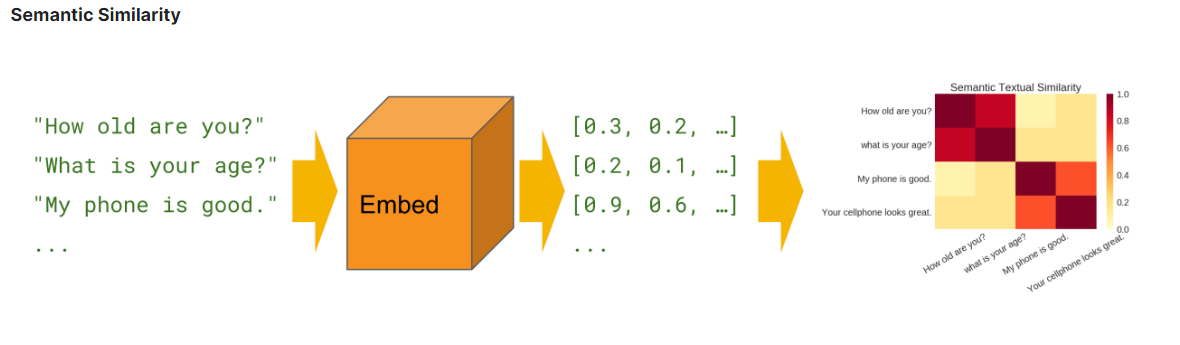

In [ ]:
#Create an embeding model using a pretrained model
import tensorflow_hub as hub
embed = hub.load("https://www.kaggle.com/models/google/universal-sentence-encoder/frameworks/TensorFlow2/variations/universal-sentence-encoder/versions/2")



In [ ]:
# Create a Keras layers using the USE pretrained layer
sentence_enconder_layer = hub.KerasLayer("https://www.kaggle.com/models/google/universal-sentence-encoder/frameworks/TensorFlow2/variations/universal-sentence-encoder/versions/2",
                                         input_shape=[], # i can take variables inputs shapes so it's better let it empty
                                         dtype=tf.string,
                                         trainable=False,
                                         name="USE")

In [ ]:
#Create the model 6

model_6 = tf.keras.Sequential([
    sentence_enconder_layer,
    layers.Dense(64, activation='relu'),
    layers.Dense(1, activation='sigmoid')
])

model_6.compile(loss="binary_crossentropy",
                optimizer=tf.keras.optimizers.Adam(),
                metrics=["accuracy"])

model_6.summary()

In [ ]:
# Fit the model

model_6_history = model_6.fit(train_sentences,
                              train_labels,
                              epochs=5,
                              validation_data=(val_sentences, val_labels),
                              callbacks=[create_tensorboard_callback(SAVE_DIR,
                                                                     "USE_pretrained")])

In [ ]:
# Make predictions on the validation dataset
model_6_pred_probs = model_6.predict(val_sentences)
model_6_pred_probs.shape, model_6_pred_probs[:10] # view the first 10

# Round out predictions and reduce to 1-dimensional array
model_6_preds = tf.squeeze(tf.round(model_6_pred_probs))
model_6_preds[:10]

# Calculate LSTM model results
model_6_results = calculate_results(y_true=val_labels,
                                    y_pred=model_6_preds)
model_6_results

## Comparing the performance of each of our models

In [ ]:

all_model_results = pd.DataFrame({'0_baseline': baseline_results,
                                  "1_Dense": model_1_results,
                                  "2_LSTM": model_2_results,
                                  "3_GRU": model_3_results,
                                  "6_USE-Pretrained": model_6_results})

all_model_results = all_model_results.transpose()

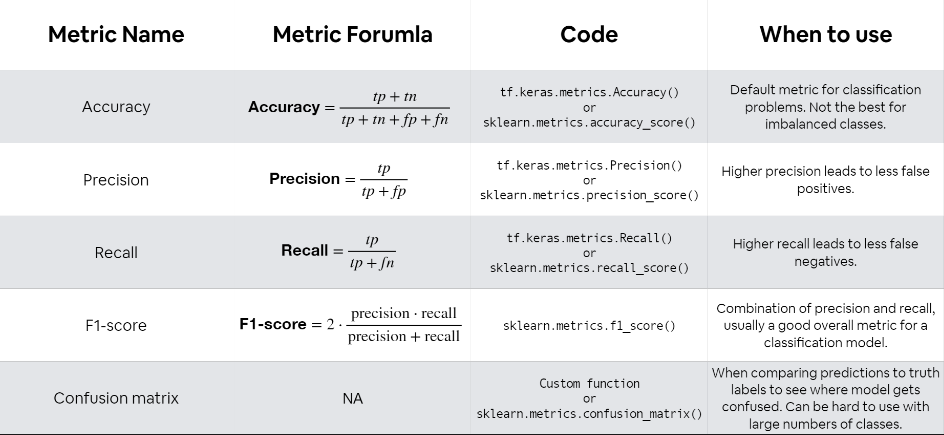

### Reduce accuracy to the same scale as other metricss

In [ ]:
all_model_results["accuracy"] = all_model_results['accuracy']/100
all_model_results

## Plot and compare

In [ ]:
all_model_results.plot(kind="bar", figsize=(10,7)).legend(bbox_to_anchor=(1.0,1.0))
plt.savefig('example_plot.svg', format='svg', transparent=False)

plt.show()

### Evaluating in TensorBoards




In [ ]:
%tensorboard --logdir ./model_logs

## Save and Load models

In [ ]:
model_6.save("model_6")

In [ ]:
loaded_model = tf.keras.models.load_model("model_6")

## Download a pretrained model

In [ ]:
!wget https://storage.googleapis.com/ztm_tf_course/08_model_6_USE_feature_extractor.zip
!unzip 08_model_6_USE_feature_extractor.zip

In [ ]:
# Make Pred
model_6_fake = tf.keras.models.load_model("08_model_6_USE_feature_extractor")

## Visualizing Predictions

In [ ]:
# Make predictions with the model
model_6_predprobs = model_6_fake.predict(val_sentences.shuffle)
model_6_pred = tf.squeeze(tf.round(model_6_pred_probs))
model_6_pred[:10]

In [ ]:
# Create a dataFrame with the validation sentences
val_df = pd.DataFrame({"text": val_sentences,
                       'target': val_labels,
                       'pred': model_6_pred,
                       "pred_prob": tf.squeeze(model_6_predprobs)})

val_df.head(10)

In [ ]:
 # Finding the most wrong predictions
most_wrong = val_df[val_df["target"] != val_df['pred']].sort_values("pred_prob", ascending = False)
most_wrong.head(20)

In [ ]:
most_wrong.tail(20)

## The Speed/Score tradeoff


In [ ]:
# How long it's takes to predict in our model
import time
def pred_timer(model, samples):

  start_time = time.perf_counter()
  model.predict(samples)
  end_time = time.perf_counter()
  total_time = (end_time - start_time)
  time_per_pred = total_time/len(samples)
  return total_time, time_per_pred


In [ ]:
total_time, time_per_pred = pred_timer(model_6, val_sentences)

total_time, time_per_pred
